In [25]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
X_train.shape, X_val.shape, X_test.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 784), (5000, 784), (10000, 784))

In [26]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [27]:
import impl.layer as l
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.grads = []
        self.W_fixed = []
        self.dy_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), 
                 b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), 
                     b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), 
                 b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn

        return dW, db

    def train_forward(self, X, train):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b'])
        y, _ = l.tanh_forward(X=y)
        X = y.copy() # pass to the next layer
        if train:
            caches.append(fc_cache)
        
        # Hidden layers
        fc_caches = []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, _ = l.tanh_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
        if train:
            caches.append(fc_caches) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches

    def onehot(self, labels):
        # y = np.zeros([labels.size, np.max(labels) + 1])
        y = np.zeros([labels.size, self.C])
        y[range(labels.size), labels] = 1.
        return y

    def squared_loss(self, y_pred, y_train):
        m = y_pred.shape[0]
        data_loss = 0.5 * np.sum((y_pred - self.onehot(y_train))**2)/ m
        return data_loss

    def dsquared_loss(self, y_pred, y_train):
        m = y_pred.shape[0]
        grad_y = (y_pred - self.onehot(y_train))/ m
        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.squared_loss(y_pred=y_prob, y_train=y_train)
        dy = self.dsquared_loss(y_pred=y_prob, y_train=y_train)
        
        return loss, dy

    def train_backward(self, dy, caches):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        dy_prev = self.dy_prev.copy() # for temporal differencing
        self.dy_prev = dy.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        dy = dy - dy_prev # temporal diff instead of differentiable function
        dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        dy =  dy @ self.W_fixed[2].T
        dy_prev =  dy_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = dy - dy_prev # temporal diff instead of differentiable function
            dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer])
            dy =  dy @ self.W_fixed[1][layer].T
            dy_prev =  dy_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache = caches[0]
        dy = dy - dy_prev # temporal diff instead of differentiable function
        dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            grads = self.train_backward(dy, caches)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
            # print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
            # format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [28]:
# Hyper-parameters
n_iter = 5000 # number of epochs
alpha = 1e-2 # learning_rate
mb_size = 100 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, n_iter=n_iter, 
       print_after=print_after)

Iter-10, train loss-0.4522, acc-0.0400, valid loss-0.4525, acc-0.0738, test loss-0.4521, acc-0.0679
Iter-20, train loss-0.4528, acc-0.0300, valid loss-0.4519, acc-0.0816, test loss-0.4515, acc-0.0772
Iter-30, train loss-0.4520, acc-0.0700, valid loss-0.4514, acc-0.0878, test loss-0.4511, acc-0.0866
Iter-40, train loss-0.4508, acc-0.1300, valid loss-0.4509, acc-0.0960, test loss-0.4506, acc-0.0952
Iter-50, train loss-0.4494, acc-0.1300, valid loss-0.4503, acc-0.1106, test loss-0.4499, acc-0.1079
Iter-60, train loss-0.4494, acc-0.1800, valid loss-0.4497, acc-0.1162, test loss-0.4494, acc-0.1146
Iter-70, train loss-0.4513, acc-0.0600, valid loss-0.4491, acc-0.1262, test loss-0.4487, acc-0.1244
Iter-80, train loss-0.4483, acc-0.1400, valid loss-0.4484, acc-0.1358, test loss-0.4480, acc-0.1346
Iter-90, train loss-0.4468, acc-0.1000, valid loss-0.4477, acc-0.1458, test loss-0.4473, acc-0.1472
Iter-100, train loss-0.4474, acc-0.1900, valid loss-0.4468, acc-0.1600, test loss-0.4465, acc-0.1578

Iter-830, train loss-0.3284, acc-0.5400, valid loss-0.2984, acc-0.6120, test loss-0.3037, acc-0.5832
Iter-840, train loss-0.3164, acc-0.5900, valid loss-0.2973, acc-0.6122, test loss-0.3026, acc-0.5845
Iter-850, train loss-0.3272, acc-0.5300, valid loss-0.2965, acc-0.6086, test loss-0.3018, acc-0.5823
Iter-860, train loss-0.3130, acc-0.5800, valid loss-0.2953, acc-0.6146, test loss-0.3005, acc-0.5878
Iter-870, train loss-0.2918, acc-0.5800, valid loss-0.2940, acc-0.6170, test loss-0.2992, acc-0.5932
Iter-880, train loss-0.3038, acc-0.6000, valid loss-0.2931, acc-0.6182, test loss-0.2982, acc-0.5942
Iter-890, train loss-0.2914, acc-0.6000, valid loss-0.2921, acc-0.6184, test loss-0.2972, acc-0.5944
Iter-900, train loss-0.2856, acc-0.6500, valid loss-0.2911, acc-0.6224, test loss-0.2961, acc-0.5972
Iter-910, train loss-0.2900, acc-0.5800, valid loss-0.2900, acc-0.6258, test loss-0.2950, acc-0.6024
Iter-920, train loss-0.3027, acc-0.5700, valid loss-0.2892, acc-0.6272, test loss-0.2943, a

Iter-1640, train loss-0.2929, acc-0.6800, valid loss-0.3043, acc-0.6252, test loss-0.3081, acc-0.6153
Iter-1650, train loss-0.3122, acc-0.6500, valid loss-0.3043, acc-0.6240, test loss-0.3080, acc-0.6123
Iter-1660, train loss-0.2935, acc-0.6800, valid loss-0.3047, acc-0.6210, test loss-0.3084, acc-0.6107
Iter-1670, train loss-0.2963, acc-0.6600, valid loss-0.3042, acc-0.6212, test loss-0.3078, acc-0.6101
Iter-1680, train loss-0.2884, acc-0.6400, valid loss-0.3037, acc-0.6236, test loss-0.3073, acc-0.6115
Iter-1690, train loss-0.3027, acc-0.6400, valid loss-0.3044, acc-0.6226, test loss-0.3081, acc-0.6098
Iter-1700, train loss-0.3284, acc-0.6200, valid loss-0.3044, acc-0.6252, test loss-0.3078, acc-0.6121
Iter-1710, train loss-0.3195, acc-0.5900, valid loss-0.3048, acc-0.6196, test loss-0.3083, acc-0.6107
Iter-1720, train loss-0.3052, acc-0.6700, valid loss-0.3056, acc-0.6202, test loss-0.3092, acc-0.6100
Iter-1730, train loss-0.3005, acc-0.6600, valid loss-0.3056, acc-0.6236, test loss

Iter-2450, train loss-0.3362, acc-0.4600, valid loss-0.3024, acc-0.5814, test loss-0.3020, acc-0.5794
Iter-2460, train loss-0.3167, acc-0.5600, valid loss-0.3022, acc-0.5880, test loss-0.3016, acc-0.5855
Iter-2470, train loss-0.3076, acc-0.5800, valid loss-0.3024, acc-0.5728, test loss-0.3019, acc-0.5739
Iter-2480, train loss-0.3070, acc-0.4900, valid loss-0.3025, acc-0.5786, test loss-0.3020, acc-0.5782
Iter-2490, train loss-0.2714, acc-0.6500, valid loss-0.3028, acc-0.5622, test loss-0.3025, acc-0.5636
Iter-2500, train loss-0.2999, acc-0.5400, valid loss-0.3025, acc-0.5686, test loss-0.3021, acc-0.5709
Iter-2510, train loss-0.3114, acc-0.5100, valid loss-0.3022, acc-0.5694, test loss-0.3017, acc-0.5737
Iter-2520, train loss-0.3182, acc-0.5700, valid loss-0.3018, acc-0.5646, test loss-0.3014, acc-0.5679
Iter-2530, train loss-0.3164, acc-0.6100, valid loss-0.3016, acc-0.5586, test loss-0.3011, acc-0.5599
Iter-2540, train loss-0.2986, acc-0.5200, valid loss-0.3018, acc-0.5604, test loss

Iter-3260, train loss-0.3163, acc-0.4800, valid loss-0.2937, acc-0.5438, test loss-0.2951, acc-0.5447
Iter-3270, train loss-0.2992, acc-0.5200, valid loss-0.2940, acc-0.5450, test loss-0.2953, acc-0.5460
Iter-3280, train loss-0.2934, acc-0.5800, valid loss-0.2939, acc-0.5498, test loss-0.2951, acc-0.5506
Iter-3290, train loss-0.2796, acc-0.5800, valid loss-0.2938, acc-0.5518, test loss-0.2951, acc-0.5536
Iter-3300, train loss-0.2815, acc-0.5500, valid loss-0.2937, acc-0.5598, test loss-0.2950, acc-0.5599
Iter-3310, train loss-0.2750, acc-0.5900, valid loss-0.2937, acc-0.5564, test loss-0.2950, acc-0.5567
Iter-3320, train loss-0.3100, acc-0.5000, valid loss-0.2932, acc-0.5596, test loss-0.2947, acc-0.5596
Iter-3330, train loss-0.2932, acc-0.5400, valid loss-0.2932, acc-0.5616, test loss-0.2947, acc-0.5612
Iter-3340, train loss-0.3021, acc-0.5800, valid loss-0.2928, acc-0.5546, test loss-0.2944, acc-0.5576
Iter-3350, train loss-0.3244, acc-0.4800, valid loss-0.2923, acc-0.5654, test loss

Iter-4070, train loss-0.2791, acc-0.6200, valid loss-0.2827, acc-0.6220, test loss-0.2869, acc-0.6093
Iter-4080, train loss-0.3130, acc-0.5700, valid loss-0.2828, acc-0.6264, test loss-0.2870, acc-0.6106
Iter-4090, train loss-0.2906, acc-0.6100, valid loss-0.2827, acc-0.6240, test loss-0.2869, acc-0.6086
Iter-4100, train loss-0.3032, acc-0.5800, valid loss-0.2825, acc-0.6258, test loss-0.2866, acc-0.6085
Iter-4110, train loss-0.3404, acc-0.5300, valid loss-0.2826, acc-0.6276, test loss-0.2866, acc-0.6111
Iter-4120, train loss-0.2976, acc-0.6300, valid loss-0.2822, acc-0.6280, test loss-0.2863, acc-0.6112
Iter-4130, train loss-0.2958, acc-0.6300, valid loss-0.2818, acc-0.6294, test loss-0.2860, acc-0.6125
Iter-4140, train loss-0.3241, acc-0.5400, valid loss-0.2820, acc-0.6216, test loss-0.2860, acc-0.6050
Iter-4150, train loss-0.2736, acc-0.6600, valid loss-0.2812, acc-0.6272, test loss-0.2854, acc-0.6108
Iter-4160, train loss-0.3132, acc-0.6200, valid loss-0.2809, acc-0.6238, test loss

Iter-4880, train loss-0.2730, acc-0.5800, valid loss-0.2698, acc-0.6348, test loss-0.2772, acc-0.6164
Iter-4890, train loss-0.2928, acc-0.5800, valid loss-0.2695, acc-0.6352, test loss-0.2772, acc-0.6136
Iter-4900, train loss-0.2508, acc-0.6500, valid loss-0.2693, acc-0.6352, test loss-0.2769, acc-0.6164
Iter-4910, train loss-0.3114, acc-0.5800, valid loss-0.2696, acc-0.6342, test loss-0.2771, acc-0.6158
Iter-4920, train loss-0.2747, acc-0.5800, valid loss-0.2696, acc-0.6358, test loss-0.2772, acc-0.6159
Iter-4930, train loss-0.2953, acc-0.6100, valid loss-0.2697, acc-0.6378, test loss-0.2771, acc-0.6183
Iter-4940, train loss-0.2499, acc-0.6800, valid loss-0.2695, acc-0.6354, test loss-0.2770, acc-0.6159
Iter-4950, train loss-0.2473, acc-0.7000, valid loss-0.2695, acc-0.6330, test loss-0.2770, acc-0.6138
Iter-4960, train loss-0.2736, acc-0.5500, valid loss-0.2692, acc-0.6330, test loss-0.2768, acc-0.6137
Iter-4970, train loss-0.3032, acc-0.5800, valid loss-0.2690, acc-0.6322, test loss

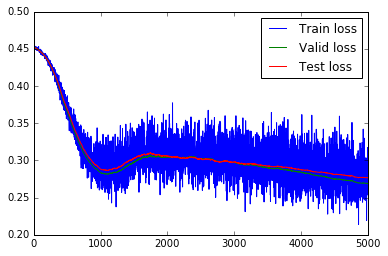

In [29]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

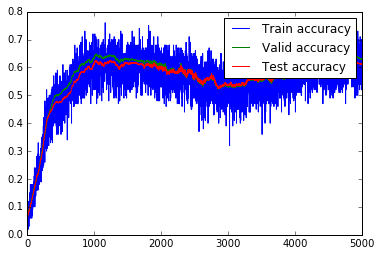

In [30]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()